In [110]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import datetime
%cd /Users/dane/src/awrjs
import js.js_pd as js_pd
c_xem = '#063CBF'
c_ana = '#EA3C00'

/Users/dane/src/awrjs


In [111]:
sim = js_pd.read_and_validate('/Users/dane//data/a/js/output/awr_v14a.csv')

# in this data set there are a couple of points in october we want to trim off
sim = sim[sim.submitted_date >= '2017-01-01'].copy()
summary = {}
summary['start'] = sim.iloc[0].submitted_date
summary['end'] = sim.iloc[len(sim)-1].submitted_date
summary['sub_cnt'] = len(sim)
summary['comp_cnt'] = sim.duration_m.count()
summary['users'] = len(sim.user.value_counts())
summary['tot_hrs'] = int(sim.duration_m.sum() / 60.0)
summary['big'] = sim.working_set.max() / 1000.
summary['machines'] = len(sim.host.value_counts())

In [112]:
# fix dates
sim.submitted_date = pd.to_datetime(sim.submitted_date)
sim.start_date = pd.to_datetime(sim.start_date)
sim.wait_m = pd.to_numeric(sim.wait_m)

In [113]:
initial_month = sim.iloc[0].submitted_date.month
initial_year  = sim.iloc[0].submitted_date.year
# we want months to start at 1 instead of 0
#sim['sub_month'] = (sim['submitted_date'].apply(lambda x: x.year) - initial_year) * 12 + sim.submitted_date.apply(lambda x: x.month) - initial_month + 1
sim['sub_month'] = sim.submitted_date.apply(lambda x: "{:.2f}".format(x.year + x.month / 100.))
sim.columns

Index(['submitted_date', 'submitted_time', 'submitted_day', 'start_date',
       'start_time', 'start_day', 'duration_m', 'wait_m', 'user', 'simulator',
       'host', 'working_set', 'priority', 'min_proc', 'threads', 'max_proc',
       'req_perf', 'req_mem', 'exit_code', 'results_copy_m', 'uuid', 'version',
       'sub_month'],
      dtype='object')

In [114]:
# some weird simulator names come in sometimes.  We only care about a few
print(len(sim))
sim = sim[sim.simulator.isin(['AXIEM', 'Analyst', 'EM_3rd_Party'])]
print(len(sim))

11278
11265


# Log File Statistics

In [115]:
print("""
The log files analyzed contain data from {start} to {end}. 

There are a total of {sub_cnt:,} jobs submitted of which {comp_cnt:,} completed. 

There are {users} separate users that have run jobs for a total of {tot_hrs:,} hours of 
of simulation on {machines} machines.

The largest job required {big} Gb of memory.
""".format(**summary)
     )


The log files analyzed contain data from 2017-02-01 to 2018-06-07. 

There are a total of 11,278 jobs submitted of which 7,214 completed. 

There are 28 separate users that have run jobs for a total of 4,072 hours of 
of simulation on 4 machines.

The largest job required 75.95698046875 Gb of memory.



# Job Submission Statistics

The graphs plot the number of jobs and average simulation time per month.  Month 1 is defined as the first month in the log file.

### Jobs per Month

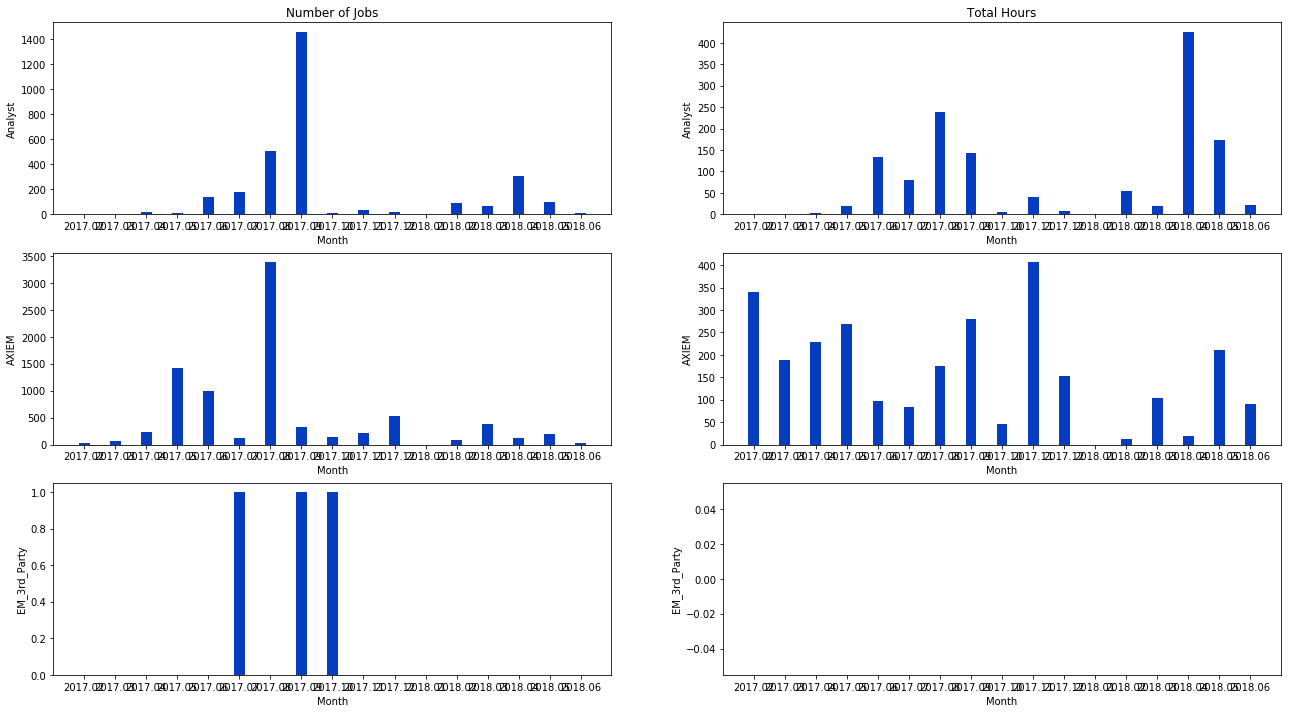

In [116]:
# axiem_bym = sim[sim.simulator=='AXIEM'].groupby('sub_month')
# analyst_bym = sim[sim.simulator=='Analyst'].groupby('sub_month')
# fig = plt.gcf()
# fig.set_size_inches(12,10)
# axiem = axiem_bym.submitted_date.count()
# analyst = analyst_bym.submitted_date.count()
# plt.figure(1)
# plt.subplot(211)
# plt.bar(axiem, axiem, .8, color=c_xem)
# plt.title('AXIEM Jobs Submitted per Month')
# plt.ylabel('Number of Jobs')
# plt.subplot(212)
# plt.bar(analyst.index-0.4, analyst, .8, color=c_ana)
# plt.title('Analyst Jobs Submitted per Month')
# plt.xlabel('Months Since Start of Log')
# plt.ylabel('Number of Jobs')
# plt.show()

em_pvt = pd.pivot_table(sim, index=['sub_month'], columns=['simulator'], values=['duration_m'],
                        aggfunc=[len, sum, np.mean], fill_value=0)
em_pvt.head()
#em_pvt['len', 'duration_m', 'AXIEM'].plot(kind='barh')
num_sims = len(sim.simulator.unique())
num_months = len(sim.sub_month.unique())


fig, ax = plt.subplots(num_sims, 2, figsize=(22, 12))
for i, sim_name in enumerate(sim.simulator.unique()):
    ind = np.arange(num_months)
    ax[i, 0].bar(ind, em_pvt['len', 'duration_m', sim_name], width=0.35, color=c_xem)
    ax[i, 0].set(xlabel='Month',
              ylabel='{}'.format(sim_name),
              xticks=ind,
              xticklabels=em_pvt['len', 'duration_m', sim_name].index)
    ax[i, 1].bar(ind, em_pvt['sum', 'duration_m', sim_name]/60., width=0.35, color=c_xem)
    ax[i, 1].set(xlabel='Month',
              ylabel='{}'.format(sim_name),
              xticks=ind,
              xticklabels=em_pvt['sum', 'duration_m', sim_name].index)
ax[0,0].set_title('Number of Jobs')
ax[0,1].set_title('Total Hours')
plt.show()

### Simulation Time per Month

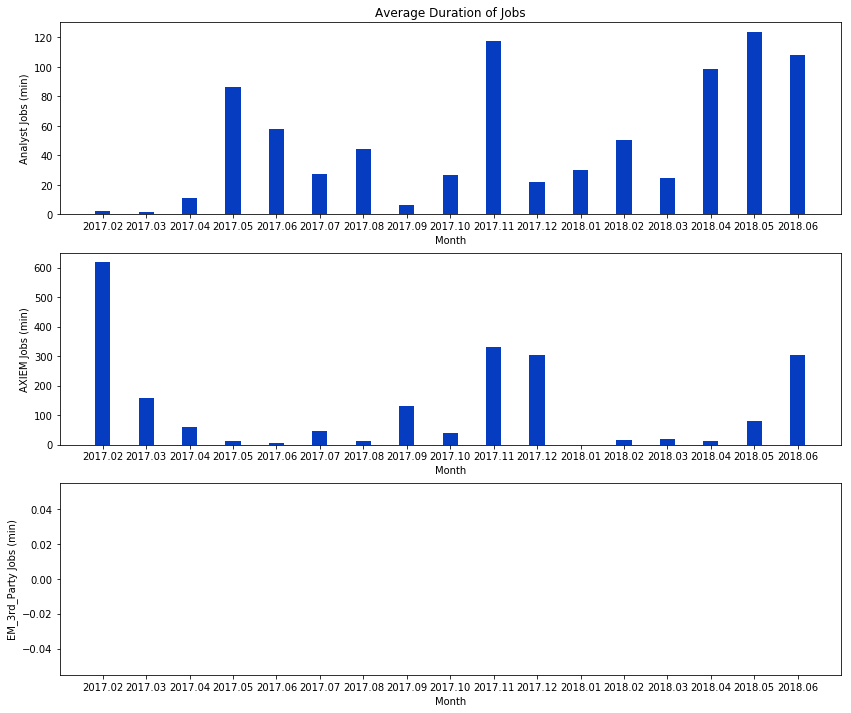

In [117]:
fig, ax = plt.subplots(num_sims, 1, figsize=(14, 12))
for i, sim_name in enumerate(sim.simulator.unique()):
    ind = np.arange(num_months)
    ax[i].bar(ind, em_pvt['mean', 'duration_m', sim_name], width=0.35, color=c_xem)
    ax[i].set(xlabel='Month',
              ylabel='{} Jobs (min)'.format(sim_name),
              xticks=ind,
              xticklabels=em_pvt['mean', 'duration_m', sim_name].index)
ax[0].set_title('Average Duration of Jobs')
plt.show()

### Simulation Durations

To get a better idea what simulations look like, here have selected time range intervals to break the simulations into
and plot the number of simulations in those range bins.

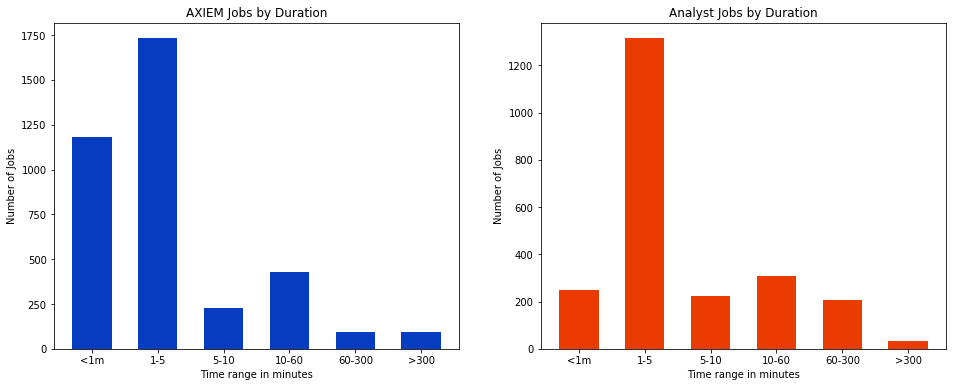

In [118]:
bins = [0, 1, 5, 10, 60, 300, 5000]
comp = js_pd.successful_jobs(sim)
axiem, bins = np.histogram(comp[comp.simulator=='AXIEM'].duration_m, bins=bins)
analyst, bins = np.histogram(comp[comp.simulator=='Analyst'].duration_m, bins=bins)

fig = plt.gcf()
fig.set_size_inches(16,6)

plt.subplot(121)
plt.bar(np.arange(len(bins)-1), axiem, .6, color=c_xem)
plt.gca().set_xticklabels(['<1m', '1-5', '5-10', '10-60', '60-300', '>300'])
plt.gca().set_xticks(np.arange(len(bins)-1))
plt.xlabel('Time range in minutes')
plt.ylabel('Number of Jobs')
plt.title('AXIEM Jobs by Duration')

plt.subplot(122)
plt.bar(np.arange(len(bins)-1), analyst, .6, color=c_ana)
plt.gca().set_xticklabels(['<1m', '1-5', '5-10', '10-60', '60-300', '>300'])
plt.gca().set_xticks(np.arange(len(bins)-1))
plt.title('Analyst Jobs by Duration')
plt.xlabel('Time range in minutes')
plt.ylabel('Number of Jobs')
plt.show()

### Memory Used

In the same way we can select memory ranges for the peak memory used by the simulations. Because there is such a large range of memory requirements, we have plotted the large jobs separately.

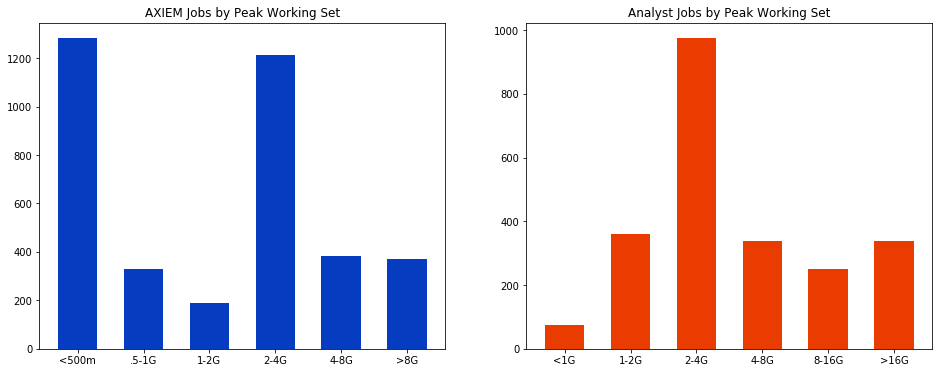

In [119]:
comp_v12 = comp[ comp.working_set.notnull()]  # to looks at mem only keep v12+

bins1 = [0, 500, 1000, 2000, 4000, 8000, 90000]
axiem, bins = np.histogram(comp_v12[comp_v12.simulator=='AXIEM'].working_set, bins=bins1)
bins2 = [0, 1000, 2000, 4000, 8000, 16000, 90000]
analyst, bins = np.histogram(comp_v12[comp_v12.simulator=='Analyst'].working_set, bins=bins2)

fig = plt.gcf()
fig.set_size_inches(16,6)


plt.subplot(121)
plt.bar(np.arange(len(bins1)-1), axiem, .6, color=c_xem)
plt.gca().set_xticklabels(['<500m', '.5-1G', '1-2G', '2-4G', '4-8G', '>8G'])
plt.gca().set_xticks(np.arange(len(bins)-1))
plt.title('AXIEM Jobs by Peak Working Set')


plt.subplot(122)
plt.bar(np.arange(len(bins2)-1), analyst, .6, color=c_ana)
plt.gca().set_xticklabels(['<1G', '1-2G', '2-4G', '4-8G', '8-16G', '>16G'])
plt.gca().set_xticks(np.arange(len(bins)-1))
plt.title('Analyst Jobs by Peak Working Set')
plt.show()

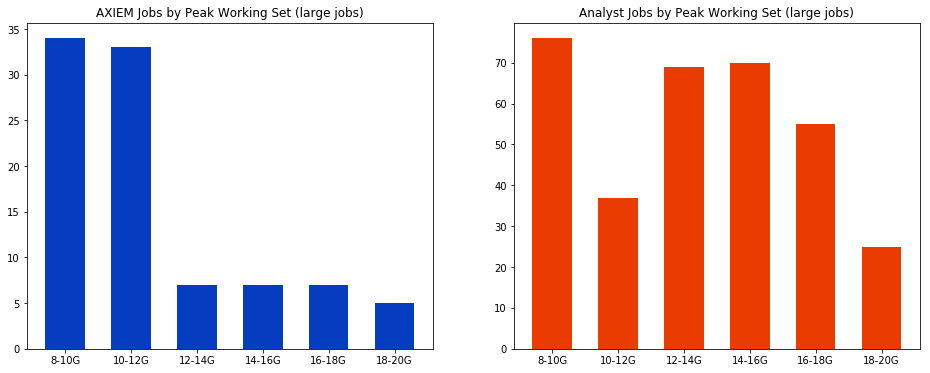

In [120]:
# Look at large memory jobs only
comp_large = comp[ comp.working_set >= 8000]  # to looks at mem only keep v12

bins1 = list(range(8000, 21000, 2000))
axiem, bins = np.histogram(comp_large[comp_large.simulator=='AXIEM'].working_set, bins=bins1)
bins2 = list(range(8000, 21000, 2000))
analyst, bins = np.histogram(comp_large[comp_large.simulator=='Analyst'].working_set, bins=bins2)

fig = plt.gcf()
fig.set_size_inches(16,6)


plt.subplot(121)
plt.bar(np.arange(len(bins1)-1), axiem, .6, color=c_xem)
plt.gca().set_xticklabels(['8-10G', '10-12G', '12-14G', '14-16G', '16-18G', '18-20G'])
plt.gca().set_xticks(np.arange(len(bins)-1))
plt.title('AXIEM Jobs by Peak Working Set (large jobs)')


plt.subplot(122)
plt.bar(np.arange(len(bins2)-1), analyst, .6, color=c_ana)
plt.gca().set_xticklabels(['8-10G', '10-12G', '12-14G', '14-16G', '16-18G', '18-20G'])
plt.gca().set_xticks(np.arange(len(bins)-1))
plt.title('Analyst Jobs by Peak Working Set (large jobs)')
plt.show()

### Memory versus Runtime

To get an appreciation of whether simulation time and memory consumption are related we plot the jobs runtime vs memory used.  Below each dot represents one completed simulation.

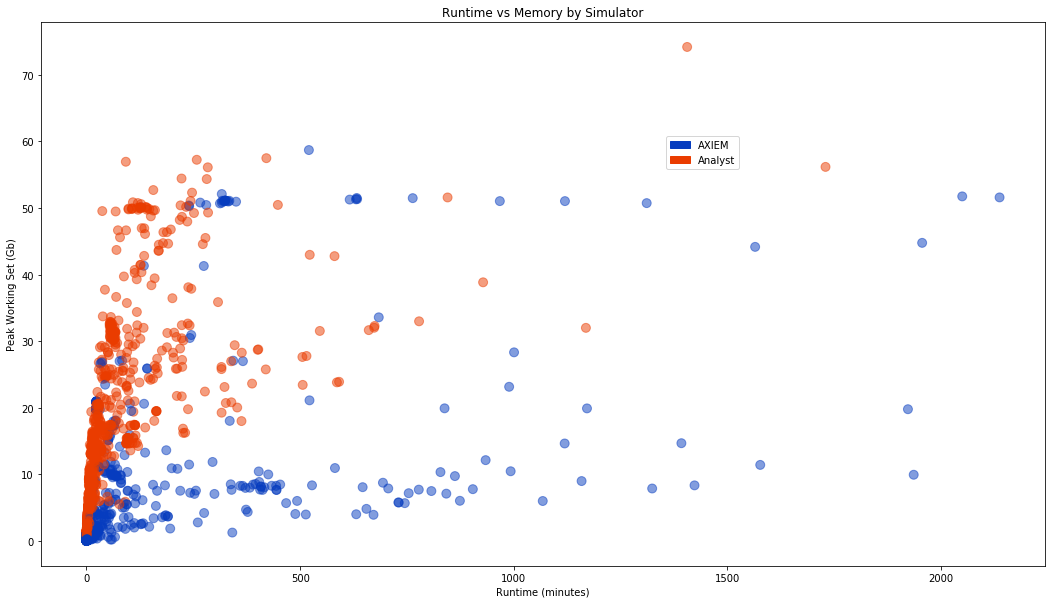

In [121]:
fig = plt.gcf()
fig.set_size_inches(18,10) 
d = comp_v12[ comp_v12.duration_m < 3000 ]
color = d.simulator.apply(lambda x: c_xem if x=='AXIEM' else c_ana)
plt.scatter(d.duration_m, d.working_set/1024, c=color, s=80, alpha=0.5)
plt.ylabel('Peak Working Set (Gb)')
plt.xlabel('Runtime (minutes)')
plt.title('Runtime vs Memory by Simulator')
xem_patch = mpatches.Patch(color=c_xem, label='AXIEM')
ana_patch = mpatches.Patch(color=c_ana, label='Analyst')
plt.legend(handles=[xem_patch, ana_patch], bbox_to_anchor=[0.7,0.8])
plt.show()

### Memory versus Time

Another point of interest is seeing the memory used over time to see if jobs are gettng larger.  We can see this by plotting the peak memory per job versus the day (the number of days since the log started). 


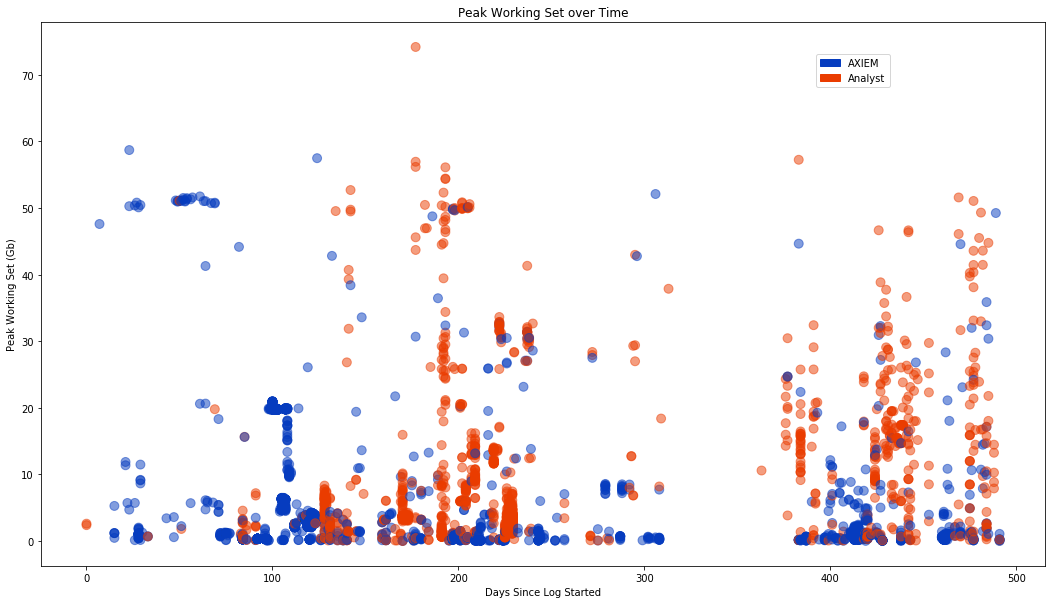

In [122]:
fig = plt.gcf()
fig.set_size_inches(18,10) 
x_ind = comp_v12.submitted_date.apply(lambda x: (x-comp_v12.iloc[0].submitted_date).days)
color = d.simulator.apply(lambda x: c_xem if x=='AXIEM' else c_ana)
plt.scatter(x_ind, comp_v12.working_set/1024, c=color, s=80, alpha=0.5)
plt.ylabel('Peak Working Set (Gb)')
plt.xlabel('Days Since Log Started')
plt.title('Peak Working Set over Time')
# plt.xlim([250,600])
# plt.ylim([0,30])
xem_patch = mpatches.Patch(color=c_xem, label='AXIEM')
ana_patch = mpatches.Patch(color=c_ana, label='Analyst')
plt.legend(handles=[xem_patch, ana_patch], bbox_to_anchor=[0.85,0.95])
plt.show()

### Queue Wait Times

Here we look at the wait time, defined as the time from job submission until simulation starts. This gives us a perspective at what could be saved with additional simulation resources.

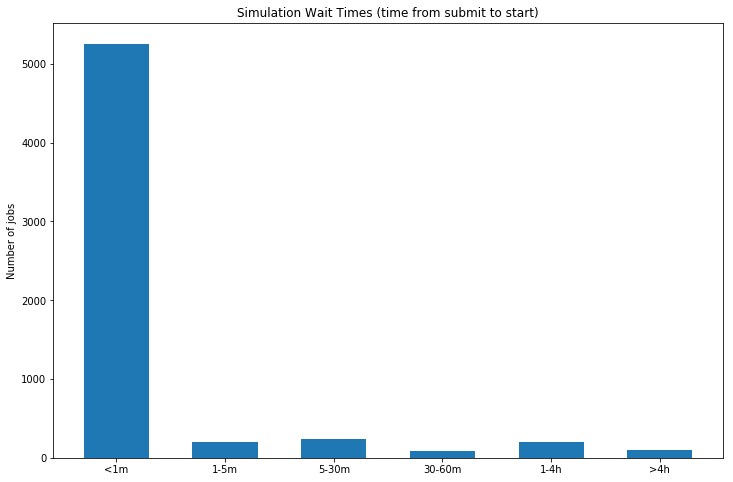

Total wait time was 2,896 hours


In [123]:
fig = plt.gcf()
fig.set_size_inches(12,8)
bins = [0, 1, 5, 30, 60, 240, 20000]
data, bins = np.histogram(comp.wait_m, bins=bins)
plt.bar(np.arange(len(bins)-1), data, .6)
plt.gca().set_xticklabels(['<1m', '1-5m', '5-30m', '30-60m', '1-4h', '>4h'])
plt.gca().set_xticks(np.arange(len(bins)-1))
plt.title('Simulation Wait Times (time from submit to start)')
plt.ylabel('Number of jobs')
plt.show()
print('Total wait time was {:,} hours'.format(int(sim.wait_m.sum()/60.0)))

### Change in Wait Times

We can also look at how wait times in a month vary over time by looking at the total wait time per month.

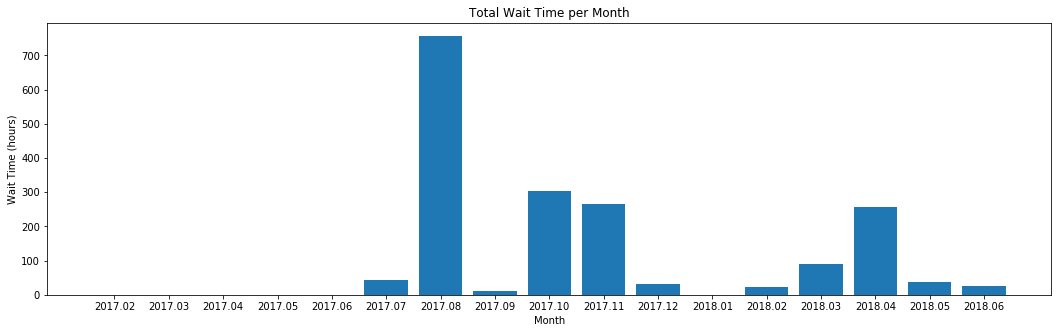

In [124]:
wait_pvt = comp.pivot_table(index=['sub_month'], values='wait_m', aggfunc=sum)
fig = plt.gcf()
fig.set_size_inches(18,5)
x_ind = np.arange(len(wait_pvt))

plt.bar(x_ind, (wait_pvt/60.).values, width=0.8)
plt.title('Total Wait Time per Month')
plt.ylabel('Wait Time (hours)')
plt.xlabel('Months Since Start of Log')
plt.gca().set(xlabel='Month',
        ylabel='Wait Time (hours)',
        xticks=ind,
        xticklabels=wait_pvt.index)
plt.show()

# Job Completion Statistics

### Jobs by Exit Type

In [125]:
js_pd.jobs_by_type(sim)

,Analyst,AXIEM,Total,EM_3rd_Party
Cancelled by User,433,4223,4656,0
Completed Successfully,2337,3762,6100,1
Host Reassigned,0,0,0,0
Jobs Submitted,2964,8298,11265,3
Other Disposition,189,278,469,2
Scheduler Shutdown,5,35,40,0


# Data by User

Here are some breakdowns by user.

### Simulation Time

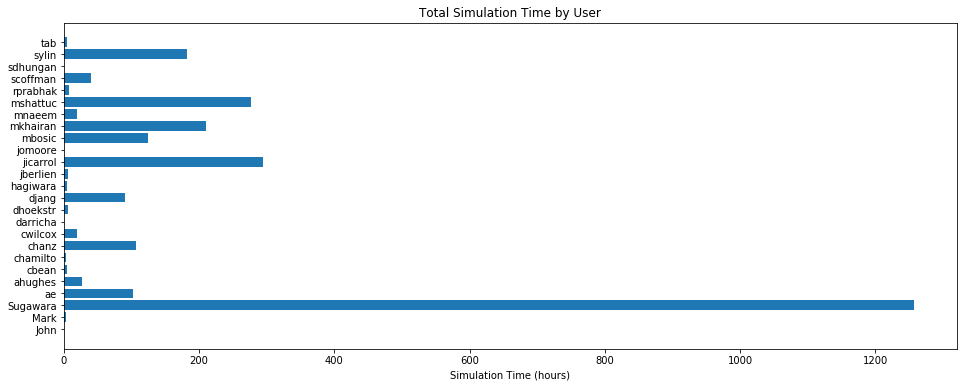

In [126]:
by_user = comp.groupby('user')
by_user_hours = by_user.duration_m.sum() / 60.0
pos = np.arange(len(by_user_hours))+.5
fig = plt.gcf()
fig.set_size_inches(16,6)     
plt.barh(pos,by_user_hours, align='center')
plt.yticks(pos, by_user_hours.index)
plt.xlabel('Simulation Time (hours)')
plt.title('Total Simulation Time by User')
plt.show()

### Number of Jobs

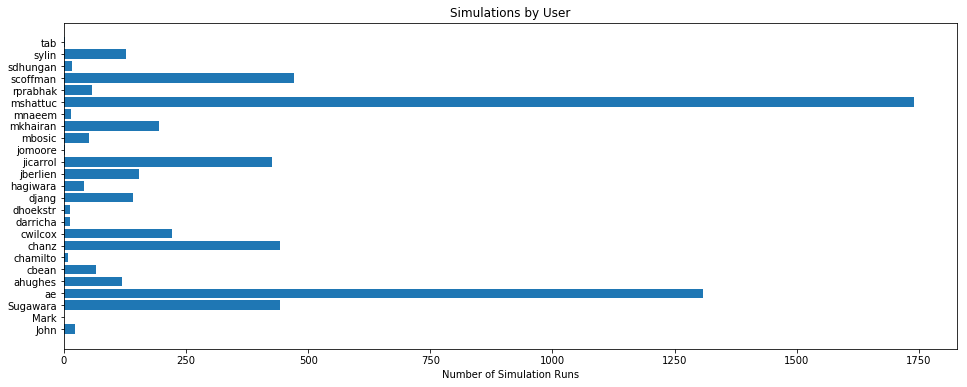

In [127]:
by_user = comp.groupby('user')
by_user_hours = by_user.user.count()
pos = np.arange(len(by_user_hours))+.5
fig = plt.gcf()
fig.set_size_inches(16,6)     
plt.barh(pos,by_user_hours, align='center')
plt.yticks(pos, by_user_hours.index)
plt.xlabel('Number of Simulation Runs')
plt.title('Simulations by User')
plt.show()

### Usage over Time

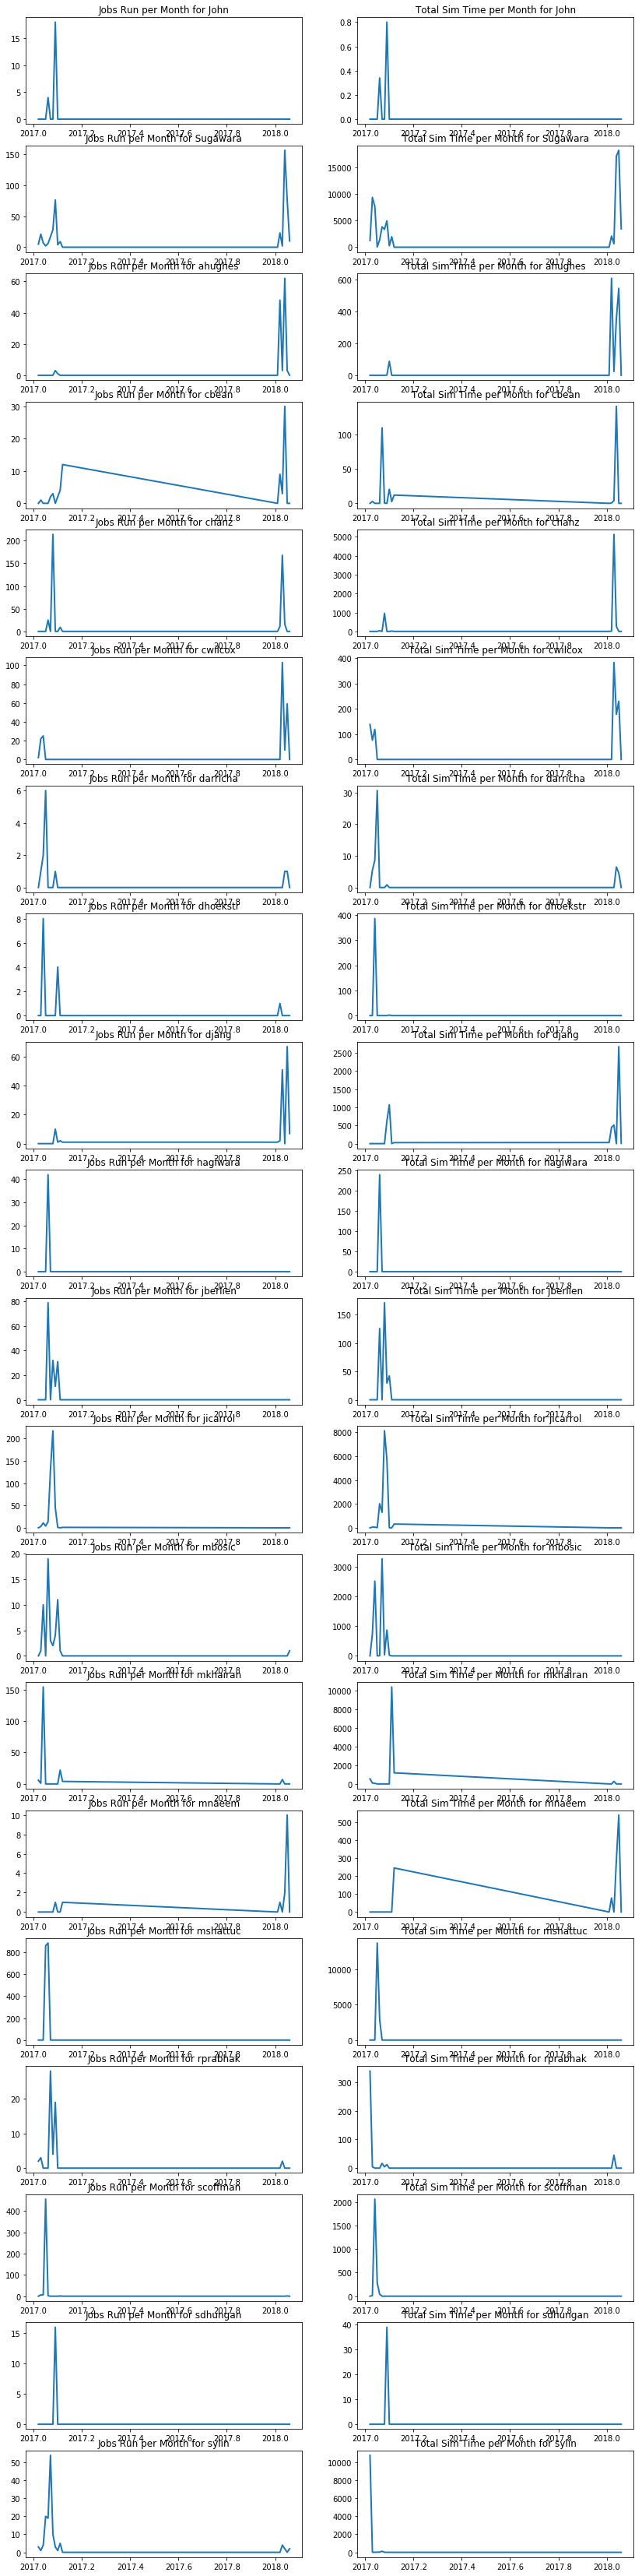

In [128]:
data = comp[~comp.user.isin(['Mark','tab','jomoore','chamilto', 'john', 'ae','jcarrol'])]
x=pd.pivot_table(data, index=['user'], columns='sub_month', values='duration_m', aggfunc=len, fill_value=0)
y=pd.pivot_table(data, index=['user'], columns='sub_month', values='duration_m', aggfunc=sum, fill_value=0)
graphs = len(x.index)
j=1
plt.figure(1, figsize=(14,graphs*3))
for user in x.index:
    plt.subplot(graphs, 2, j)
    j += 1
    plt.plot(x.T[user], linewidth=2)
    plt.title('Jobs Run per Month for {}'.format(user))
    plt.subplot(graphs, 2, j)
    j += 1
    plt.plot(y.T[user], linewidth=2)
    plt.title('Total Sim Time per Month for {}'.format(user))
plt.show()

# Data by Computer

### Simulation Time

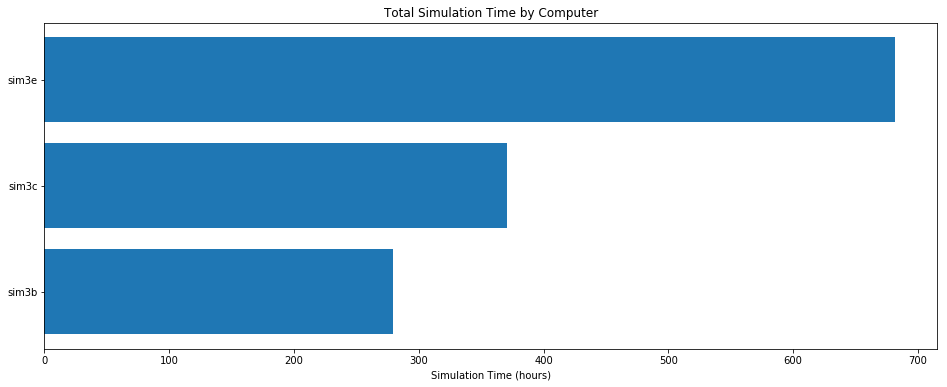

In [129]:
by_host = comp[comp.host != 'local service'].groupby('host')
by_host_hours = by_host.duration_m.sum() / 60.0
pos = np.arange(len(by_host_hours))+.5
fig = plt.gcf()
fig.set_size_inches(16,6)     
plt.barh(pos,by_host_hours, align='center')
plt.yticks(pos, by_host_hours.index)
plt.xlabel('Simulation Time (hours)')
plt.title('Total Simulation Time by Computer')
plt.show()

### Number of Jobs

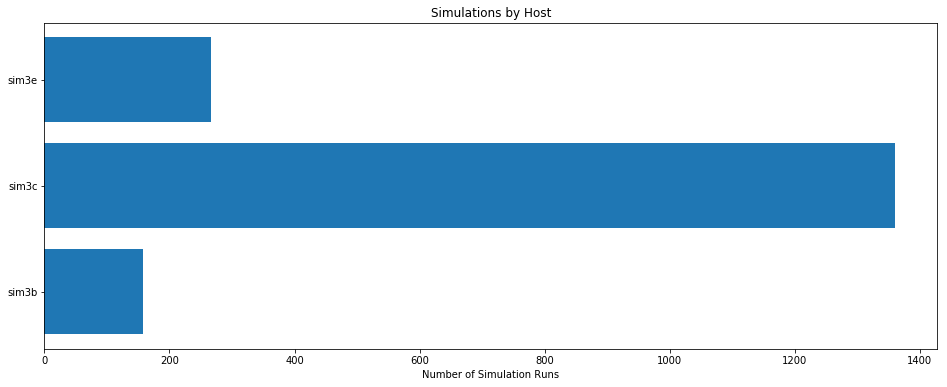

In [130]:
by_host = comp[(comp.host != 'local service') & (comp.simulator == 'Analyst')].groupby('host')
by_host_count = by_host.host.count()
pos = np.arange(len(by_host_count))+.5
fig = plt.gcf()
fig.set_size_inches(16,6)     
plt.barh(pos,by_host_count, align='center')
plt.yticks(pos, by_host_count.index)
plt.xlabel('Number of Simulation Runs')
plt.title('Simulations by Host')
plt.show()

# How Averages Change Over Time

The scatter plot of memory does a good job of tracking evolution of the large jobs over time but
does not give us much insight on the average job.  For this a box plot can provide more insight.

*Note:* Since there are a large number of outliers these graphs are zoomed in (in the Y direction) to 
allow the boxes to be clearly seen.

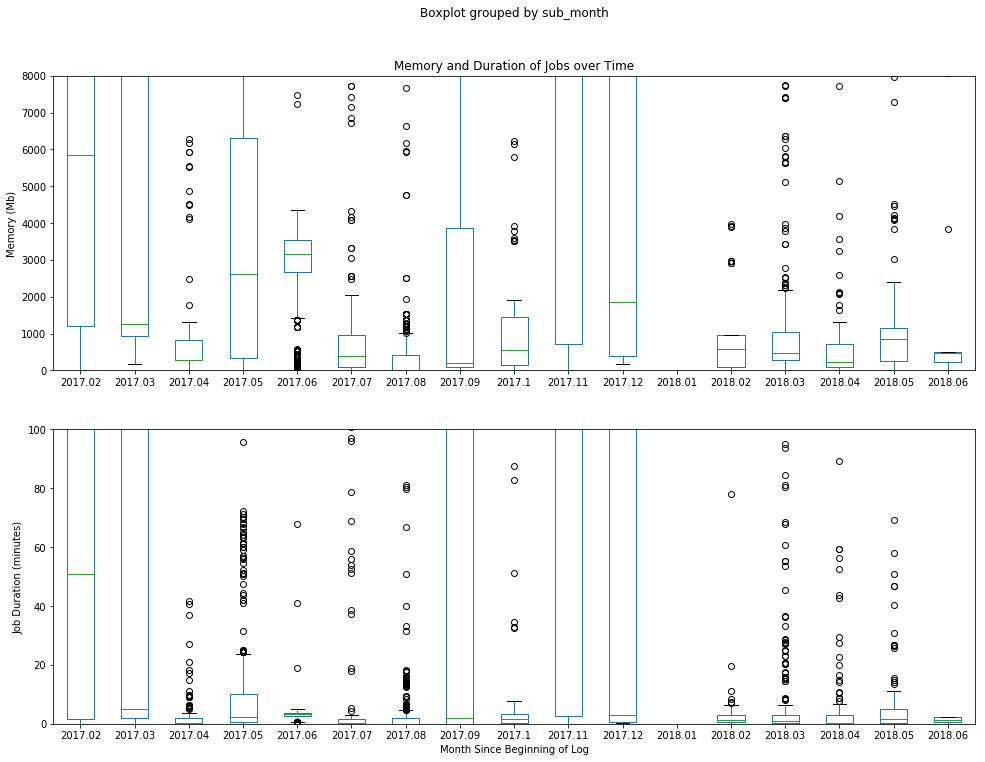

In [140]:
data = sim[(sim.simulator=='AXIEM')].copy()
data.sub_month = pd.to_numeric(data.sub_month)
fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_size_inches(16,12)
ax = data.boxplot(column='working_set', by='sub_month', ax=ax1, grid=False)
ax.set_xlabel('')
ax.set_ylabel('Memory (Mb)')
ax.set_ylim([0,8000])
ax.set_title('Memory and Duration of Jobs over Time')

ax = data.boxplot(column='duration_m', by='sub_month', ax=ax2, grid=False)
ax.set_xlabel('Month Since Beginning of Log')
ax.set_ylabel('Job Duration (minutes)')
ax.set_ylim([0,100])
ax.set_title('')
plt.show()

# Network Copy Performance

After a simulation is done the results must be copied back to the user.  Over a typical network this time is small but is it network dependent. An interesting thing to look at is the average time to copy results back per day (since network problems tend to last longer than just 1 job).

In this case, we combine all the successful jobs by day and look at the number of jobs, the average copy time in minutes and the longest copy time in minutes. Then we just keep the days where the average copy time was over 1 minute.


In [144]:
piv = pd.pivot_table(comp, index=["start_date"], values=['results_copy_m'],
                     aggfunc=[len, np.mean, max], fill_value=0)
piv[piv['mean']['results_copy_m'] > 1]

,len,mean,max
,results_copy_m,results_copy_m,results_copy_m
start_date,,,


from this we see that that coy times are largely insignificant on most days but there are specific days when something is going wrong.  This is something that may be correlated with networking issues.  The recommendation here is to collect more data from users and see if this data tracks with other networking issues or if it is perculiar to the job scheduler.

# Final Notes

The raw data is available as a CSV file to allow you to perform additional analysis.

This section provides some of the above data in tabular form for those interested.

**NOTE: In the tables below 'len' is an abbreviation for lenght and denotes the count.  For example in the first table the 'len duration_m' denotes the number of jobs.  Likewise, 'sum duration_m' denotes the total sum of the durations in minutes.**

### User Information

In [ ]:
pd.pivot_table(sim, index=['user'],  columns=['simulator'], values=['duration_m'], aggfunc=[len, sum, np.median], fill_value=0)

### Host Information

In [ ]:
pd.pivot_table(sim, index=['host'],  columns=['simulator'], values=['duration_m'], aggfunc=[len, sum, np.median], fill_value=0)

### Simulator Information

In [ ]:
pd.pivot_table(sim, index=['simulator'],  values=['duration_m'], aggfunc=[len, sum, np.median], fill_value=0)